# Optimizer Example
Jena Climate RNN example showing comparsion between Adam and *newer* optimizers.
This is a regression model, using 3-hour data.

Richard Henry, 26-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
plt.style.use('fivethirtyeight')

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.17.0'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

|Dataset|Architecture|Group|Type|
|---|---|---|---|
|Jena 3hr|RNN|Modern|Regression|

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 2.16 s
Wall time: 2.3 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model functions
def model_core():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1,
                                  activation='linear')
        ]
    )
    return model
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model=model_core()
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    # Reduce variation in training...
    tf.random.set_seed(17)
    print("History Match:")
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    print("\n")
    print("Evaluate Model:")
    myEva=model.evaluate(xTrain,
                         y_train,
                         batch_size=bat_len)
    print("All Sample MSE:",myEva[0])
    print("All Sample MAE:",myEva[1])
    print("\n")
    print("Make Predictions:")
    myPre=model.predict(xTrain)
    print("\n")
    print("Timing:")
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build('adam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - loss: 133.3668 - mean_absolute_error: 9.4961 - val_loss: 70.5511 - val_mean_absolute_error: 6.6766
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - loss: 48.3842 - mean_absolute_error: 5.4991 - val_loss: 40.0309 - val_mean_absolute_error: 4.8696
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - loss: 29.5625 - mean_absolute_error: 4.2214 - val_loss: 29.5478 - val_mean_absolute_error: 4.1441
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - loss: 23.2432 - mean_absolute_error: 3.7253 - val_loss: 24.5077 - val_mean_absolute_error: 3.7405
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 20.9629 - mean_absolute_error: 3.5555 - val_loss: 23.1486 - val_mean_absolute_error: 3.6764
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - loss: 19.2380 - mean_absolute_error: 3.4114 - val_loss: 20.4507 - val_mean_absolute_error: 3.4353
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 17.4638 - m

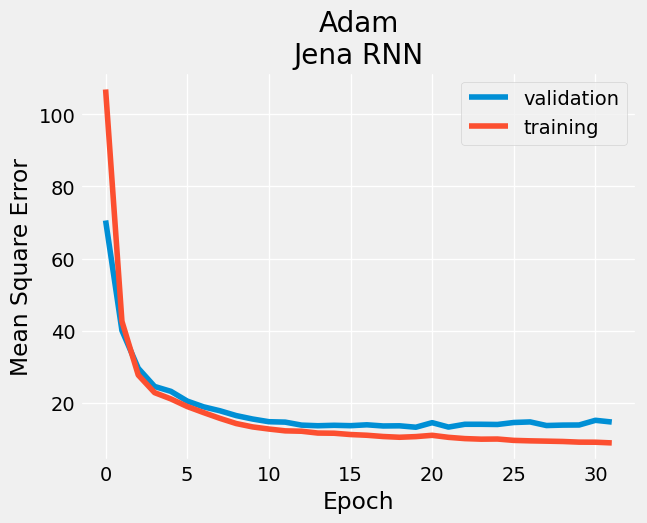

In [40]:
plt.plot(h0.history['val_loss'])
plt.plot(h0.history['loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam\nJena RNN')
plt.grid(color='white')
plt.show()

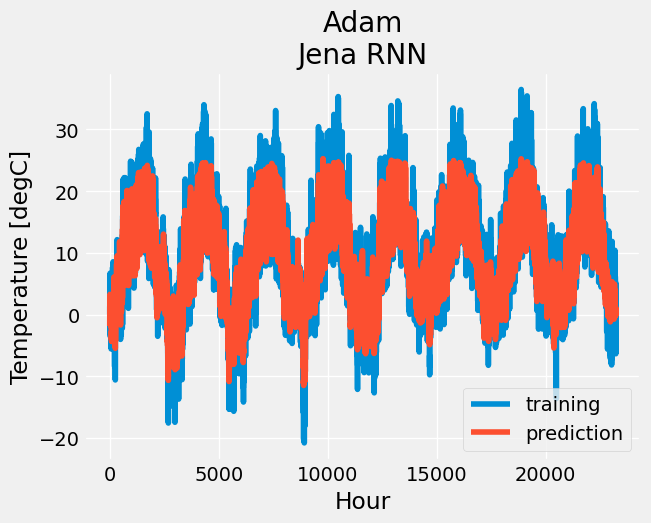

In [39]:
plt.plot(y_train)
plt.plot(p0.flatten())
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam\nJena RNN')
plt.grid(color='white')
plt.show()

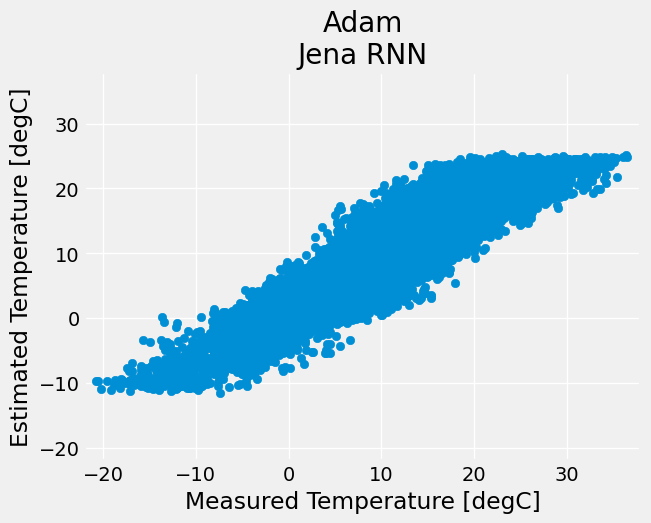

In [38]:
plt.scatter(y_train,p0.flatten())
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam\nJena RNN')
plt.grid(color='white')
plt.xlim([-22,38])
plt.ylim([-22,38])
plt.show()

### Second Model, Adam with Weight Decay

In [16]:
%%time
h1,p1=model_build('adamw')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - loss: 130.5244 - mean_absolute_error: 9.4413 - val_loss: 71.8291 - val_mean_absolute_error: 6.7844
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - loss: 49.7777 - mean_absolute_error: 5.5853 - val_loss: 44.0487 - val_mean_absolute_error: 5.2148
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 32.7951 - mean_absolute_error: 4.4580 - val_loss: 33.1800 - val_mean_absolute_error: 4.3943
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - loss: 26.4706 - mean_absolute_error: 3.9961 - val_loss: 26.1754 - val_mean_absolute_error: 3.8542
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - loss: 22.7060 - mean_absolute_error: 3.7032 - val_loss: 24.5537 - val_mean_absolute_error: 3.7371
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - loss: 20.5436 - mean_absolute_error: 3.5206 - val_loss: 21.8025 - val_mean_absolute_error: 3.5544
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 18.519

### Third Model, AdaFactor

In [17]:
%%time
h2,p2=model_build('adafactor')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - loss: 158.7441 - mean_absolute_error: 10.4078 - val_loss: 199.7937 - val_mean_absolute_error: 11.8156
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - loss: 152.2231 - mean_absolute_error: 10.1844 - val_loss: 192.6132 - val_mean_absolute_error: 11.5908
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - loss: 145.1041 - mean_absolute_error: 9.9312 - val_loss: 184.5583 - val_mean_absolute_error: 11.3260
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - loss: 136.9023 - mean_absolute_error: 9.6264 - val_loss: 174.6165 - val_mean_absolute_error: 10.9816
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - loss: 126.3064 - mean_absolute_error: 9.2122 - val_loss: 161.2638 - val_mean_absolute_error: 10.4952
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - loss: 112.8601 - mean_absolute_error: 8.6534 - val_loss: 142.9715 - val_mean_absolute_error: 9.7822
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step

### 4th Model, LION

In [18]:
%%time
h3,p3=model_build('lion')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - loss: 131.8680 - mean_absolute_error: 9.4420 - val_loss: 80.7611 - val_mean_absolute_error: 7.2538
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - loss: 60.1939 - mean_absolute_error: 6.2106 - val_loss: 59.5270 - val_mean_absolute_error: 6.3193
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - loss: 59.5908 - mean_absolute_error: 6.1583 - val_loss: 59.3817 - val_mean_absolute_error: 6.3072
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - loss: 54.7455 - mean_absolute_error: 5.9190 - val_loss: 60.6666 - val_mean_absolute_error: 6.3319
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - loss: 51.6319 - mean_absolute_error: 5.7366 - val_loss: 59.9498 - val_mean_absolute_error: 6.3136
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - loss: 51.4944 - mean_absolute_error: 5.7026 - val_loss: 55.1893 - val_mean_absolute_error: 5.9908
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - loss: 47.195

### 5th Model, Adam with Nesterov Momentum

In [19]:
%%time
h4,p4=model_build('nadam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 271ms/step - loss: 138.4571 - mean_absolute_error: 9.6528 - val_loss: 66.8453 - val_mean_absolute_error: 6.5195
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - loss: 43.1480 - mean_absolute_error: 5.1295 - val_loss: 39.9159 - val_mean_absolute_error: 4.8830
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - loss: 28.1847 - mean_absolute_error: 4.0890 - val_loss: 30.8658 - val_mean_absolute_error: 4.2976
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - loss: 23.8798 - mean_absolute_error: 3.7909 - val_loss: 26.2371 - val_mean_absolute_error: 3.9595
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - loss: 21.2470 - mean_absolute_error: 3.5915 - val_loss: 23.7513 - val_mean_absolute_error: 3.7759
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - loss: 19.4937 - mean_absolute_error: 3.4349 - val_loss: 20.8340 - val_mean_absolute_error: 3.5316
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - loss: 17.8300 

### 6th Model, Follow the Regularized Leader

In [20]:
%%time
h5,p5=model_build('ftrl')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - loss: 152.6175 - mean_absolute_error: 10.2387 - val_loss: 187.4327 - val_mean_absolute_error: 11.5040
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - loss: 149.6209 - mean_absolute_error: 10.1445 - val_loss: 184.9117 - val_mean_absolute_error: 11.4428
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - loss: 146.9343 - mean_absolute_error: 10.0607 - val_loss: 181.9015 - val_mean_absolute_error: 11.3678
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - loss: 143.4280 - mean_absolute_error: 9.9498 - val_loss: 177.1926 - val_mean_absolute_error: 11.2444
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - loss: 137.5049 - mean_absolute_error: 9.7573 - val_loss: 166.1959 - val_mean_absolute_error: 10.9278
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - loss: 122.1788 - mean_absolute_error: 9.2033 - val_loss: 129.6084 - val_mean_absolute_error: 9.6087
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/

### 7th Model, AdaMax

In [21]:
%%time
h6,p6=model_build('adamax')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - loss: 138.5821 - mean_absolute_error: 9.7575 - val_loss: 106.1653 - val_mean_absolute_error: 8.5721
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - loss: 62.9650 - mean_absolute_error: 6.2784 - val_loss: 57.0767 - val_mean_absolute_error: 5.9363
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - loss: 37.7297 - mean_absolute_error: 4.7485 - val_loss: 39.3552 - val_mean_absolute_error: 4.8190
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - loss: 29.7770 - mean_absolute_error: 4.2249 - val_loss: 32.8606 - val_mean_absolute_error: 4.3752
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - loss: 26.0472 - mean_absolute_error: 3.9489 - val_loss: 29.3654 - val_mean_absolute_error: 4.1287
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - loss: 24.2003 - mean_absolute_error: 3.8242 - val_loss: 26.9509 - val_mean_absolute_error: 3.9512
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - loss: 22.6818 

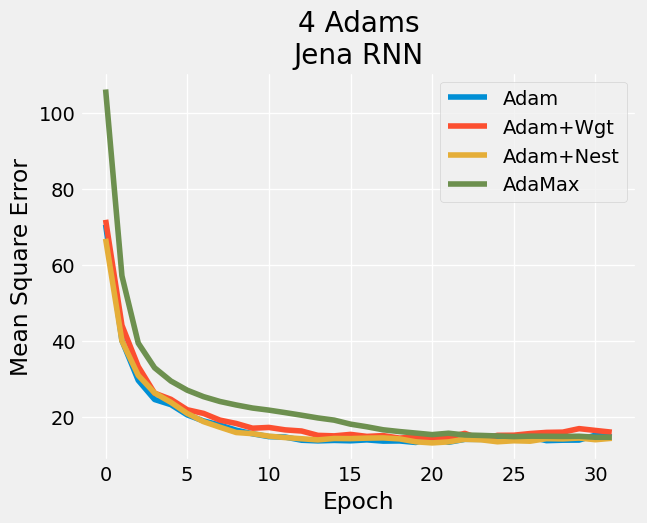

In [37]:
plt.plot(h0.history['val_loss'])
plt.plot(h1.history['val_loss'])
plt.plot(h4.history['val_loss'])
plt.plot(h6.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','AdaMax'])
plt.title('4 Adams\nJena RNN')
plt.grid(color='white')
plt.show()

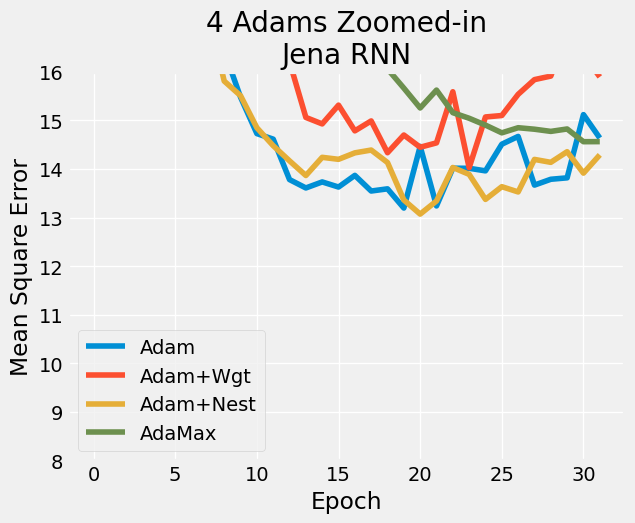

In [36]:
plt.plot(h0.history['val_loss'])
plt.plot(h1.history['val_loss'])
plt.plot(h4.history['val_loss'])
plt.plot(h6.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','Adam+Wgt','Adam+Nest','AdaMax'])
plt.title('4 Adams Zoomed-in\nJena RNN')
plt.ylim([8,16])
plt.grid(color='white')
plt.show()

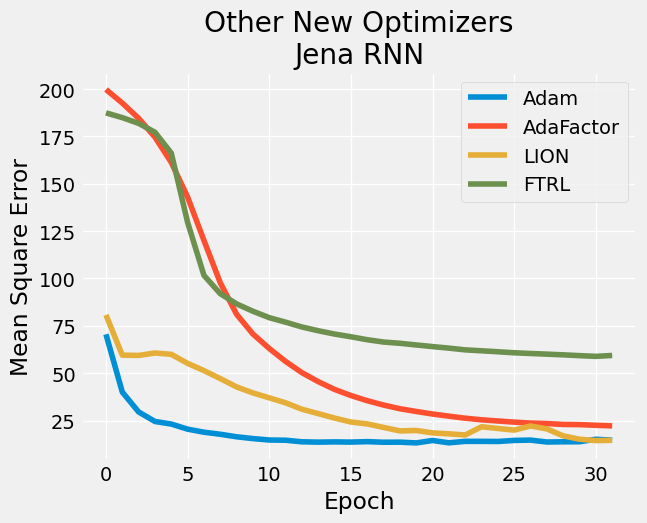

In [35]:
plt.plot(h0.history['val_loss'])
plt.plot(h2.history['val_loss'])
plt.plot(h3.history['val_loss'])
plt.plot(h5.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaFactor','LION','FTRL'])
plt.title('Other New Optimizers\nJena RNN')
plt.grid(color='white')
plt.show()

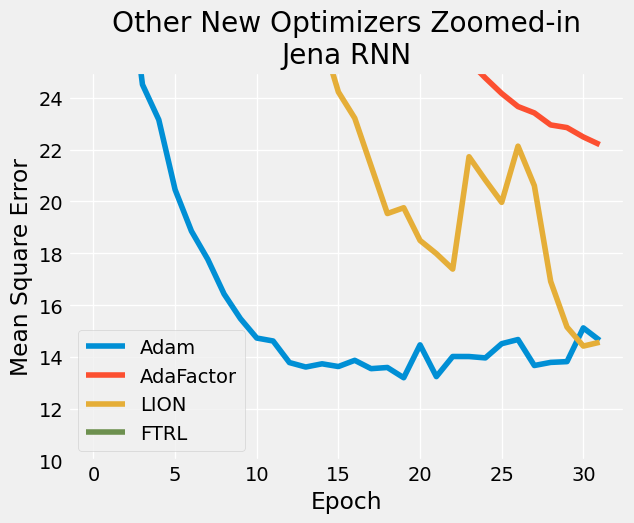

In [41]:
plt.plot(h0.history['val_loss'])
plt.plot(h2.history['val_loss'])
plt.plot(h3.history['val_loss'])
plt.plot(h5.history['val_loss'])
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaFactor','LION','FTRL'])
plt.title('Other New Optimizers Zoomed-in\nJena RNN')
plt.ylim([10,25])
plt.grid(color='white')
plt.show()

## Model Summary

In [26]:
m=model_core()
m.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 128, 11)             │              23 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,544 (76.35 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 23 (96.00 B)